### Setup and importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

### Data Analysis

In [2]:
dataset_path = "TrashType_Image_Dataset"
all_dimensions_set = set()

# iterate over the datset
garbage_types = os.listdir(dataset_path)
print(garbage_types)

['metal', 'paper', 'plastic']


In [5]:
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    # iterate over the images in the dataset    
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg",".jpeg",".png"))]
        # display the count of images in each folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images")
        
        # check the dimensions of the images
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                img = img.resize((224, 224)) # resize the image to 224x224
                width, height = img.size
                channels = len(img.getbands()) # get number of color channels
                all_dimensions_set.add((width, height, channels))
                
# Determin if all images have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channels = all_dimensions_set.pop()
    print(f"All images have the same dimensions: {width} x {height} x {channels}")
    
else:
    print("Images have different dimensions")

metal folder contains 410 images
paper folder contains 594 images
plastic folder contains 482 images
All images have the same dimensions: 224 x 224 x 3


#### To display a few images

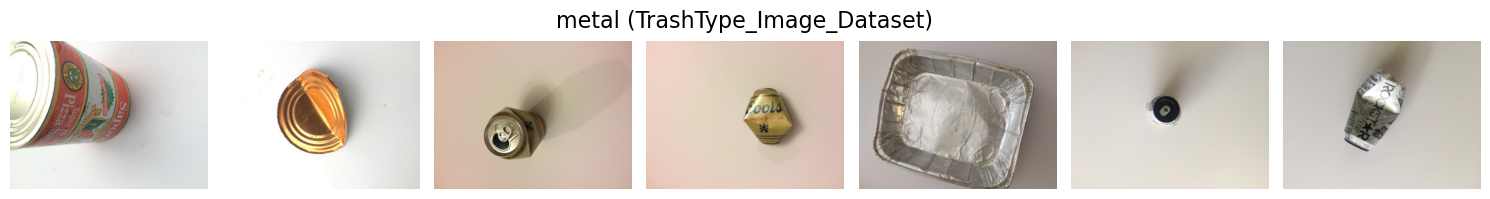

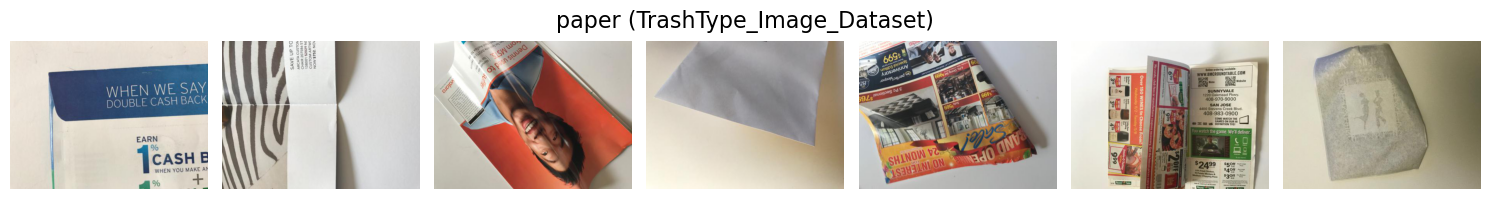

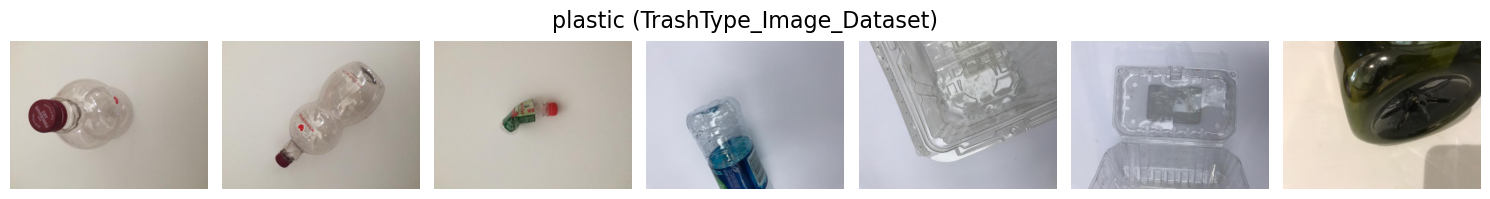

In [6]:
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # verify current item is a folder
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg",".jpeg",".png"))]
        
        # select first 7 images from the folder
        image_files = image_files[:7]
        
        # setup subplots
        fig, axs = plt.subplots(1, 7, figsize=(15,2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis("off")
        
        plt.tight_layout()
        fig.suptitle(f"{garbage_type} ({os.path.basename(dataset_path)})", fontsize=16, y=1.03)
        plt.show()


#### Create a list to store image file paths and respective labels

In [11]:
data = []
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith((".jpg",".jpeg",".png")):
        # Ensire valid image formats
                data.append((os.path.join(folder_path,file), garbage_type))

df = pd.DataFrame(data, columns=["filepath","label"])

# display dataset information
print(f"Total images in dataset: {df.shape[0]}")
print("Class distribution:\n", df["label"].value_counts())



Total images in dataset: 1486
Class distribution:
 paper      594
plastic    482
metal      410
Name: label, dtype: int64


In [12]:
df.head()

,filepath,label
0,TrashType_Image_Dataset\metal\metal_001.jpg,metal
1,TrashType_Image_Dataset\metal\metal_002.jpg,metal
2,TrashType_Image_Dataset\metal\metal_003.jpg,metal
3,TrashType_Image_Dataset\metal\metal_004.jpg,metal
4,TrashType_Image_Dataset\metal\metal_005.jpg,metal


### Splitting Train and Validation

In [13]:
# Train(80%), validation(10%) and test(10%) split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df["label"])

In [14]:
# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")
print(f"Number of images in the test set: {len(test_df)}")

Number of images in the training set: 1188
Number of images in the validation set: 149
Number of images in the test set: 149


In [15]:
# Class distributions in percentages
overall_distribution = df['label'].value_counts(normalize=True) * 100
train_distribution = train_df['label'].value_counts(normalize=True) * 100
val_distribution = val_df['label'].value_counts(normalize=True) * 100
test_distribution = test_df['label'].value_counts(normalize=True) * 100

# Print distributions
print("\nClass distribution in the entire dataset:\n", overall_distribution.round(2))
print('-'*40)
print("\nClass distribution in the training set:\n", train_distribution.round(2))
print('-'*40)
print("\nClass distribution in the validation set:\n", val_distribution.round(2))
print('-'*40)
print("\nClass distribution in the test set:\n", test_distribution.round(2))


Class distribution in the entire dataset:
 paper      39.97
plastic    32.44
metal      27.59
Name: label, dtype: float64
----------------------------------------

Class distribution in the training set:
 paper      39.98
plastic    32.41
metal      27.61
Name: label, dtype: float64
----------------------------------------

Class distribution in the validation set:
 paper      40.27
plastic    32.21
metal      27.52
Name: label, dtype: float64
----------------------------------------

Class distribution in the test set:
 paper      39.60
plastic    32.89
metal      27.52
Name: label, dtype: float64


### Loading ResNet50 with Pre-trained Weights

In [16]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 11s 0us/step


In [17]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
len(base_model.layers) 

175

In [19]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [20]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [21]:
# Build the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  # Updated to 3 classes

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), 
                                loss='categorical_crossentropy', 
                                metrics=['accuracy'])

In [23]:
transfer_resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=60,                
    width_shift_range=0.15,            
    height_shift_range=0.15,           
    zoom_range=0.20,                   
    horizontal_flip=True,              
    vertical_flip=True,                
    shear_range=0.05,                  
    brightness_range=[0.9, 1.1],       
    channel_shift_range=10,            
    fill_mode='nearest',               
    preprocessing_function=preprocess_input  
)

# No augmentation for validation & test sets, only preprocessing
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [26]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  
    x_col="filepath",                    
    y_col="label",                       
    target_size=(224, 224),              # 🔥 Updated to match ResNet50 input size
    batch_size=32,                       
    class_mode='categorical',            
    seed=42,                             
    shuffle=True                         
)

Found 1188 validated image filenames belonging to 3 classes.


In [27]:
# Validation data generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,                    
    x_col="filepath",                    
    y_col="label",                       
    target_size=(224, 224),              
    batch_size=32,                       
    class_mode='categorical',            
    seed=42,                             
    shuffle=False                        
)

Found 149 validated image filenames belonging to 3 classes.


In [28]:
# Test data generator (NEW)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,                    
    x_col="filepath",                    
    y_col="label",                       
    target_size=(224, 224),              
    batch_size=32,                       
    class_mode='categorical',            
    seed=42,                             
    shuffle=False                        
)

Found 149 validated image filenames belonging to 3 classes.


In [29]:
# Print batch counts
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")
print(f"Number of batches in test_generator: {len(test_generator)}")

Number of batches in train_generator: 38
Number of batches in val_generator: 5
Number of batches in test_generator: 5


In [30]:
# Print class indices
train_generator.class_indices

{'metal': 0, 'paper': 1, 'plastic': 2}

In [33]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure class order matches train_generator
sorted_classes = sorted(train_generator.class_indices, key=train_generator.class_indices.get)

# Map class labels to indices
class_indices = train_generator.class_indices  # {'battery': 0, 'biological': 1, ...}
y_numeric = train_df['label'].map(class_indices)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_numeric), y=y_numeric)

# Convert computed weights to a dictionary
class_weights = {class_indices[cls]: weight for cls, weight in zip(sorted_classes, weights)}

print("Final Computed Class Weights:", class_weights)

Final Computed Class Weights: {0: 1.2073170731707317, 1: 0.8336842105263158, 2: 1.0285714285714285}


### Fine-tuning the Transfer Learning ResNet50 Model

In [31]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

In [34]:
# Train the model
num_epochs = 50

history = transfer_resnet50_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=num_epochs,
    validation_data=val_generator, 
    validation_steps=len(val_generator),
    class_weight=class_weights,  # Applying computed class weights
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


KeyboardInterrupt: 

### Evaluating the Transfer Learning ResNet50 Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import LinearSegmentedColormap
import requests
from io import BytesIO
from PIL import Image

def plot_learning_curves(history, start_epoch=1):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from model.fit()).
    - start_epoch: Epoch from which to start plotting. Default is 1.
    """

    # Convert history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot curves from specified epoch onwards
    df = df.iloc[start_epoch - 1:]

    # Seaborn styling
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    plt.figure(figsize=(15, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

plot_learning_curves(history, start_epoch=1)

NameError: name 'history' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

def evaluate_model_performance(model, test_generator, class_labels):
    """
    Evaluate the model's performance on the test set, print accuracy, and classification report.

    Parameters:
    - model: The trained model.
    - test_generator: Test data generator.
    - class_labels: List of class names.
    """
    
    true_labels = test_generator.classes  # True labels
    test_generator.reset()
    
    # Model predictions
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class indices
    confidence_scores = np.max(predictions, axis=1)    # Confidence scores

    # Compute test accuracy
    test_accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%\n")

    # Classification Report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", ["white", "royalblue"])

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return confidence_scores  # Return confidence scores for further analysis if needed

# Evaluate model
confidence_scores = evaluate_model_performance(transfer_resnet50_model, test_generator, class_labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_predictions(test_generator, model, class_labels, num_samples=10):
    """
    Selects random images from the test set, predicts them, and visualizes results with confidence scores.

    Parameters:
    - test_generator: Keras ImageDataGenerator for testing.
    - model: Trained deep learning model.
    - class_labels: List of class names.
    - num_samples: Number of random images to display.
    """
    test_generator.reset()
    x_batch, y_batch = test_generator.next()  # Get a random batch

    random_indices = np.random.choice(len(x_batch), size=num_samples, replace=False)
    random_images = x_batch[random_indices]
    true_labels = np.argmax(y_batch[random_indices], axis=1)

    predictions = model.predict(random_images)
    predicted_labels = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1) * 100  # Convert to percentage

    # Plot predictions with confidence scores
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(random_images[i].astype("uint8"))
        plt.axis("off")
        plt.title(f"True: {class_labels[true_labels[i]]}\n"
                  f"Pred: {class_labels[predicted_labels[i]]}\n"
                  f"Conf: {confidence_scores[i]:.2f}%", fontsize=9)

    plt.tight_layout()
    plt.show()

# Plot test set predictions
plot_random_predictions(test_generator, transfer_resnet50_model, class_labels, num_samples=10)